In [0]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving train.zip to train.zip


In [0]:
!ls

sample_data  train_articles  train.json  train.zip


In [0]:
!unzip train.zip

Archive:  train.zip
   creating: train_articles/
  inflating: train.json              
  inflating: train_articles/55701.txt  
  inflating: train_articles/134107.txt  
  inflating: train_articles/45107.txt  
  inflating: train_articles/89894.txt  
  inflating: train_articles/123173.txt  
  inflating: train_articles/86133.txt  
  inflating: train_articles/9062.txt  
  inflating: train_articles/91887.txt  
  inflating: train_articles/93338.txt  
  inflating: train_articles/60364.txt  
  inflating: train_articles/58197.txt  
  inflating: train_articles/152215.txt  
  inflating: train_articles/111602.txt  
  inflating: train_articles/97543.txt  
  inflating: train_articles/101058.txt  
  inflating: train_articles/57647.txt  
  inflating: train_articles/63102.txt  
  inflating: train_articles/58351.txt  
  inflating: train_articles/111310.txt  
  inflating: train_articles/77728.txt  
  inflating: train_articles/14417.txt  
  inflating: train_articles/110546.txt  
  inflating: train_articles

In [0]:
import json
import numpy as np


# load metadata
with open("train.json", 'r') as f:
    metadata = json.load(f)
n_claims = len(metadata)

In [0]:
import torch
import torch.nn as nn
import numpy as np
import random

In [0]:
!pip install bpemb
from bpemb import BPEmb

In [0]:
n_embedding_dims = 50
bpemb_en = BPEmb(lang="en", dim=n_embedding_dims)

def sampleClaim(metadata): 
    id = random.randint(0, len(metadata) - 1)
    claim = metadata[id]["claim"]
    embedding = bpemb_en.embed(claim)
    embedding = np.reshape(embedding,(embedding.shape[0],1,embedding.shape[1]))
    label = metadata[id]["label"]
    label_tensor = torch.tensor([label], dtype=torch.long)
    claim_tensor = torch.tensor(embedding, dtype=torch.float)
    return claim_tensor, label_tensor, claim, label, id
  
  
def sampleClaimAndClaimant(metadata): 
    id = random.randint(0, len(metadata) - 1)
    claim = metadata[id]["claim"] + ' ' + metadata[id]["claimant"]
    embedding = bpemb_en.embed(claim)
    embedding = np.reshape(embedding,(embedding.shape[0],1,embedding.shape[1]))
    label = metadata[id]["label"]
    label_tensor = torch.tensor([label], dtype=torch.long)
    claim_tensor = torch.tensor(embedding, dtype=torch.float)
    return claim_tensor, label_tensor, claim, label, id

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [0]:
from torch.autograd import Variable
import math
import copy

class PositionalEncoder(nn.Module):
    def __init__(self, d_model, max_seq_len = 80):
        super().__init__()
        self.d_model = d_model
        
        # create constant 'pe' matrix with values dependant on 
        # pos and i
        pe = torch.zeros(max_seq_len, d_model)
        for pos in range(max_seq_len):
            for i in range(0, d_model, 2):
                pe[pos, i] = math.sin(pos / (10000 ** (i / d_model)))
                pe[pos, i + 1] = math.cos(pos / (10000 ** (i / d_model)))
                
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)
 
    
    def forward(self, x):
        # make embeddings relatively larger
        x = x * math.sqrt(self.d_model)
        # add constant to embedding
        seq_len = x.size(1)
        x = x + Variable(self.pe[:,:seq_len], requires_grad=False) #.cuda()
        return x

In [0]:
import torch.nn.functional as F

def attention(q, k, v, d_k, mask=None, dropout=None):
    
    scores = torch.matmul(q, k.transpose(-2, -1)) /  math.sqrt(d_k)
    if mask is not None:
        mask = mask.unsqueeze(1)
        scores = scores.masked_fill(mask == 0, -1e9)
    
    scores = F.softmax(scores, dim=-1)
    
    if dropout is not None:
        scores = dropout(scores)
        
    output = torch.matmul(scores, v)
    return output

In [0]:
class MultiHeadAttention(nn.Module):
    def __init__(self, heads, d_model, dropout = 0.1):
        super().__init__()
        
        self.d_model = d_model
        self.d_k = d_model // heads
        self.h = heads
        
        self.q_linear = nn.Linear(d_model, d_model)
        self.v_linear = nn.Linear(d_model, d_model)
        self.k_linear = nn.Linear(d_model, d_model)
        self.dropout = nn.Dropout(dropout)
        self.out = nn.Linear(d_model, d_model)
    
    def forward(self, q, k, v, mask=None):
        
        bs = q.size(0)
        
        # perform linear operation and split into h heads
        
        k = self.k_linear(k).view(bs, -1, self.h, self.d_k)
        q = self.q_linear(q).view(bs, -1, self.h, self.d_k)
        v = self.v_linear(v).view(bs, -1, self.h, self.d_k)
                
        # transpose to get dimensions bs * h * sl * d_model
       
        k = k.transpose(1,2)
        q = q.transpose(1,2)
        v = v.transpose(1,2)
        
        # calculate attention using function we will define next
        scores = attention(q, k, v, self.d_k, mask, self.dropout)
        
        # concatenate heads and put through final linear layer
        concat = scores.transpose(1,2).contiguous().view(bs, -1, self.d_model)
        
        output = self.out(concat)
    
        return output

In [0]:
class FeedForward(nn.Module):
    def __init__(self, d_model, d_ff=2048, dropout = 0.1):
        super().__init__() 
        # We set d_ff as a default to 2048
        self.linear_1 = nn.Linear(d_model, d_ff)
        self.dropout = nn.Dropout(dropout)
        self.linear_2 = nn.Linear(d_ff, d_model)
    
    def forward(self, x):
        x = self.dropout(F.relu(self.linear_1(x)))
        x = self.linear_2(x)
        return x

In [0]:
class Norm(nn.Module):
    def __init__(self, d_model, eps = 1e-6):
        super().__init__()
    
        self.size = d_model
        # create two learnable parameters to calibrate normalisation
        self.alpha = nn.Parameter(torch.ones(self.size))
        self.bias = nn.Parameter(torch.zeros(self.size))
        self.eps = eps
    
    def forward(self, x):
        norm = self.alpha * (x - x.mean(dim=-1, keepdim=True)) \
        / (x.std(dim=-1, keepdim=True) + self.eps) + self.bias
        return norm

In [0]:
# build an encoder layer with one multi-head attention layer and one 
# feed-forward layer
class EncoderLayer(nn.Module):
    def __init__(self, d_model, heads, dropout = 0.1):
        super().__init__()
        self.norm_1 = Norm(d_model)
        self.norm_2 = Norm(d_model)
        self.attn = MultiHeadAttention(heads, d_model)
        self.ff = FeedForward(d_model)
        self.dropout_1 = nn.Dropout(dropout)
        self.dropout_2 = nn.Dropout(dropout)
        
    def forward(self, x, mask):
        x2 = self.norm_1(x)
        x = x + self.dropout_1(self.attn(x2,x2,x2,mask))
        x2 = self.norm_2(x)
        x = x + self.dropout_2(self.ff(x2))
        return x

      
# We can then build a convenient cloning function that can generate multiple layers:
def get_clones(module, N):
    return nn.ModuleList([copy.deepcopy(module) for i in range(N)])

In [0]:
class Encoder(nn.Module):
    def __init__(self, d_model, N, heads):
        super().__init__()
        self.N = N
        self.pe = PositionalEncoder(d_model)
        self.layers = get_clones(EncoderLayer(d_model, heads), N)
        self.norm = Norm(d_model)
    
    def forward(self, src, mask):
        x = self.pe(src)
        for i in range(N):
            x = self.layers[i](x, mask)
        return self.norm(x)

In [0]:
class Transformer(nn.Module):
    def __init__(self, d_model, N, heads):
        super().__init__()
        self.encoder = Encoder(d_model, N, heads)
        
    def forward(self, src, src_mask):
        e_outputs = self.encoder(src, src_mask)
        output = torch.sum(e_outputs, dim=0)
        return output

In [0]:
# from Q2a
class Classifier(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(Classifier, self).__init__()
        self.hidden_size = hidden_size
        self.h2o = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, hidden):
        hidden = self.h2o(hidden)
        output = self.softmax(hidden)
        return output

# Training

In [0]:
d_model = 50   # 200
heads = 2      # 8
N = 6
n_categories = 3
model = Transformer(d_model, N, heads)
classifier = Classifier(d_model, n_categories)

criterion = nn.NLLLoss()
learning_rate = 1e-4

optim = torch.optim.Adam(model.parameters(), lr=learning_rate)
classifierOptimizer = torch.optim.Adam(classifier.parameters(), lr=learning_rate)

In [0]:
def train(category_tensor, line_tensor, update=True):
    optim.zero_grad()
    classifierOptimizer.zero_grad()

    hidden = model(line_tensor, None)
    output = classifier(hidden)

    loss = criterion(output, category_tensor)
    if update:
        loss.backward()
        optim.step()
        classifierOptimizer.step()
        
    return output, loss.item()

In [0]:
import time

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


In [0]:
n_iters = 100000
plot_every = 1000

# Keep track of losses for plotting
current_loss = 0
all_losses = []

start = time.time()

train_data = metadata[:10000]
test_data = metadata[10000:]

train_cumulative_loss = 0
test_cumulative_loss = 0
average_train_accuracy = 0
average_test_accuracy = 0

all_train_losses = []
all_train_accuracies = []
all_test_losses = []
all_test_accuracies = []

count = 0
for iter in range(1, n_iters + 1):
    train_line_tensor, train_category_tensor, train_line, train_category, train_id = sampleClaim(train_data)
    train_output, train_loss = train(train_category_tensor, train_line_tensor)    
    top_train_value, top_train_index = train_output.topk(1)
    train_guess_category = top_train_index[0].item()
    train_cumulative_loss += train_loss
    train_accuracy = 1 if train_guess_category == train_category else 0
    average_train_accuracy = (average_train_accuracy * count + train_accuracy) / (count+1)
    
    test_line_tensor, test_category_tensor, test_line, test_category, test_id = sampleClaim(test_data)
    test_output, test_loss = train(test_category_tensor, test_line_tensor, update=False)
    top_test_value, top_test_index = test_output.topk(1)
    test_guess_category = top_test_index[0].item()
    test_cumulative_loss += test_loss
    test_accuracy = 1 if test_guess_category == test_category else 0
    average_test_accuracy = (average_test_accuracy * count + test_accuracy) / (count+1)
    count += 1

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        train_correct = '✓' if train_guess_category == train_category else '✗ (%s)' % train_category
        print('Train: %d  %d%% (%s) average_accuracy=%.4f average_loss=%.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), average_train_accuracy, train_cumulative_loss / plot_every, train_line, train_guess_category, train_correct))
        test_correct = '✓' if test_guess_category == test_category else '✗ (%s)' % test_category
        print('Test: %d  %d%% (%s) average_accuracy=%.4f average_loss=%.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), average_test_accuracy, test_cumulative_loss / plot_every, test_line, test_guess_category, test_correct))
        
        all_train_losses.append(train_cumulative_loss / plot_every)
        all_train_accuracies.append(average_train_accuracy)
        all_test_losses.append(test_cumulative_loss / plot_every)
        all_test_accuracies.append(average_test_accuracy)
        
        train_cumulative_loss = 0
        average_train_accuracy = 0
        test_cumulative_loss = 0
        average_test_accuracy = 0
        count = 0

Train: 1000  1% (2m 17s) average_accuracy=0.4230 average_loss=7.2244 Al Gore's residence uses considerably more energy than the average American home. / 1 ✓
Test: 1000  1% (2m 17s) average_accuracy=0.4400 average_loss=5.7218 "The Congressional Budget Office -- supposedly non-partisan -- estimates that in just a few years the average cost to every family of four (from cap and trade) will be $6,800 per year." / 1 ✗ (0)
Train: 2000  2% (4m 28s) average_accuracy=0.4410 average_loss=4.6178 The Affordable Care Act is "not the law of the land." / 1 ✗ (0)
Test: 2000  2% (4m 28s) average_accuracy=0.4090 average_loss=6.3342 Refugees are throwing rocks and trying "to kill you." / 1 ✗ (0)
Train: 3000  3% (6m 42s) average_accuracy=0.4360 average_loss=3.9637 President Trump signed a bill blocking Obama-era background checks that would have made it easier to flag mentally ill potential gun purchasers. / 0 ✗ (1)
Test: 3000  3% (6m 42s) average_accuracy=0.4310 average_loss=3.2535 President Obama ordere

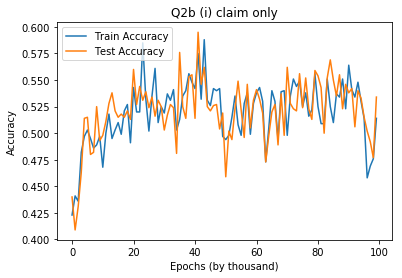

In [0]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(all_train_accuracies)
plt.plot(all_test_accuracies)
plt.title('Q2b (i) claim only')
plt.ylabel('Accuracy')
plt.xlabel('Epochs (by thousand)')
plt.legend(['Train Accuracy', 'Test Accuracy'], loc='upper left')

In [0]:
all_train_accuracies

[0.4230000000000001,
 0.44099999999999995,
 0.436,
 0.48200000000000015,
 0.4970000000000002,
 0.5029999999999999,
 0.4949999999999991,
 0.4859999999999999,
 0.48900000000000027,
 0.4970000000000004,
 0.468,
 0.5000000000000002,
 0.5179999999999995,
 0.49500000000000005,
 0.5030000000000011,
 0.5099999999999991,
 0.498999999999999,
 0.521,
 0.5270000000000007,
 0.4910000000000001,
 0.5430000000000003,
 0.5200000000000016,
 0.5199999999999996,
 0.5849999999999994,
 0.5319999999999989,
 0.5020000000000001,
 0.5350000000000004,
 0.5610000000000005,
 0.5099999999999997,
 0.5249999999999998,
 0.5189999999999989,
 0.537,
 0.5310000000000002,
 0.5409999999999998,
 0.5029999999999988,
 0.5130000000000002,
 0.5349999999999996,
 0.54,
 0.556,
 0.5479999999999998,
 0.5420000000000004,
 0.5749999999999997,
 0.5320000000000005,
 0.5879999999999997,
 0.5309999999999998,
 0.5260000000000001,
 0.5419999999999986,
 0.5400000000000003,
 0.5420000000000001,
 0.49700000000000044,
 0.494,
 0.49799999999999

In [0]:
all_test_accuracies

[0.4400000000000001,
 0.40900000000000014,
 0.431,
 0.463,
 0.5139999999999995,
 0.5149999999999993,
 0.48,
 0.482,
 0.5250000000000009,
 0.49300000000000116,
 0.49800000000000016,
 0.511000000000001,
 0.5279999999999991,
 0.5380000000000001,
 0.5210000000000011,
 0.5149999999999981,
 0.5180000000000007,
 0.5149999999999989,
 0.5209999999999995,
 0.5129999999999998,
 0.5600000000000003,
 0.5270000000000005,
 0.5439999999999996,
 0.5310000000000014,
 0.5389999999999996,
 0.5240000000000005,
 0.5340000000000005,
 0.5159999999999992,
 0.5309999999999998,
 0.5249999999999997,
 0.5030000000000003,
 0.5169999999999993,
 0.527,
 0.524000000000001,
 0.4809999999999999,
 0.5760000000000007,
 0.5249999999999991,
 0.5139999999999989,
 0.5529999999999995,
 0.5549999999999989,
 0.5140000000000001,
 0.5950000000000002,
 0.5460000000000006,
 0.5620000000000009,
 0.5250000000000006,
 0.5209999999999989,
 0.526,
 0.5270000000000005,
 0.5039999999999998,
 0.519,
 0.4589999999999999,
 0.5019999999999999,

In [0]:
d_model = 50
heads = 2
N = 6
n_categories = 3
model = Transformer(d_model, N, heads)
classifier = Classifier(d_model, n_categories)

criterion = nn.NLLLoss()
learning_rate = 1e-4

optim = torch.optim.Adam(model.parameters(), lr=learning_rate)
classifierOptimizer = torch.optim.Adam(classifier.parameters(), lr=learning_rate)

In [0]:
# Keep track of losses for plotting
current_loss = 0
all_losses = []

start = time.time()

train_data = metadata[:10000]
test_data = metadata[10000:]
train_cumulative_loss = 0
test_cumulative_loss = 0
average_train_accuracy = 0
average_test_accuracy = 0
all_train_losses_2 = []
all_train_accuracies_2 = []
all_test_losses_2 = []
all_test_accuracies_2 = []
count = 0
for iter in range(1, n_iters + 1):
    train_line_tensor, train_category_tensor, train_line, train_category, train_id = sampleClaimAndClaimant(train_data)
    train_output, train_loss = train(train_category_tensor, train_line_tensor)    
    top_train_value, top_train_index = train_output.topk(1)
    train_guess_category = top_train_index[0].item()
    train_cumulative_loss += train_loss
    train_accuracy = 1 if train_guess_category == train_category else 0
    average_train_accuracy = (average_train_accuracy * count + train_accuracy) / (count+1)
    
    test_line_tensor, test_category_tensor, test_line, test_category, test_id = sampleClaimAndClaimant(test_data)
    test_output, test_loss = train(test_category_tensor, test_line_tensor, update=False)
    top_test_value, top_test_index = test_output.topk(1)
    test_guess_category = top_test_index[0].item()
    test_cumulative_loss += test_loss
    test_accuracy = 1 if test_guess_category == test_category else 0
    average_test_accuracy = (average_test_accuracy * count + test_accuracy) / (count+1)
    count += 1

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        train_correct = '✓' if train_guess_category == train_category else '✗ (%s)' % train_category
        print('Train: %d  %d%% (%s) average_accuracy=%.4f average_loss=%.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), average_train_accuracy, train_cumulative_loss / plot_every, train_line, train_guess_category, train_correct))
        test_correct = '✓' if test_guess_category == test_category else '✗ (%s)' % test_category
        print('Test: %d  %d%% (%s) average_accuracy=%.4f average_loss=%.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), average_test_accuracy, test_cumulative_loss / plot_every, test_line, test_guess_category, test_correct))
        all_train_losses_2.append(train_cumulative_loss / plot_every)
        all_train_accuracies_2.append(average_train_accuracy)
        all_test_losses_2.append(test_cumulative_loss / plot_every)
        all_test_accuracies_2.append(average_test_accuracy)
        train_cumulative_loss = 0
        average_train_accuracy = 0
        test_cumulative_loss = 0
        average_test_accuracy = 0
        count = 0
        

Train: 1000  1% (0m 53s) average_accuracy=0.4420 average_loss=4.4052 Tendulkar, Kohli, Indian celebrities join BJP multiple sources / 2 ✗ (0)
Test: 1000  1% (0m 53s) average_accuracy=0.4300 average_loss=3.6530  "We have no [trade] deficit [with Canada], but that doesn't include energy and timber. But when you do we lose $17 billion a year."  Donald Trump / 1 ✗ (0)
Train: 2000  2% (1m 46s) average_accuracy=0.4650 average_loss=1.5501 Acclaimed actor Morgan Freeman died in October 2017 at the age of 80.  / 0 ✓
Test: 2000  2% (1m 46s) average_accuracy=0.4460 average_loss=1.6631 Bowe Bergdahl wanders off during court-martial Duffel Blog / 0 ✓
Train: 3000  3% (2m 39s) average_accuracy=0.4710 average_loss=1.4555 No, these photos do not show Muslims being tortured and killed in Myanmar multiple sources / 0 ✓
Test: 3000  3% (2m 39s) average_accuracy=0.4770 average_loss=1.6167 A video shows U.S. President Donald Trump removing his hat and revealing that he's bald.  / 0 ✓
Train: 4000  4% (3m 33s)

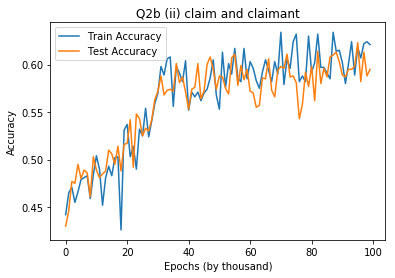

In [0]:
plt.figure()
plt.plot(all_train_accuracies_2)
plt.plot(all_test_accuracies_2)
plt.title('Q2b (ii) claim and claimant')
plt.ylabel('Accuracy')
plt.xlabel('Epochs (by thousand)')
plt.legend(['Train Accuracy', 'Test Accuracy'], loc='upper left')

In [0]:
all_train_accuracies_2

[0.442,
 0.4650000000000001,
 0.4709999999999999,
 0.45499999999999996,
 0.46599999999999986,
 0.479,
 0.4810000000000001,
 0.48300000000000026,
 0.4590000000000001,
 0.484,
 0.5039999999999992,
 0.48999999999999994,
 0.452,
 0.48100000000000004,
 0.4930000000000001,
 0.4829999999999999,
 0.5019999999999999,
 0.5030000000000001,
 0.4260000000000001,
 0.5309999999999998,
 0.5370000000000007,
 0.5030000000000018,
 0.5140000000000006,
 0.4900000000000001,
 0.5319999999999994,
 0.5250000000000002,
 0.553999999999999,
 0.5240000000000006,
 0.5410000000000005,
 0.5589999999999999,
 0.5700000000000007,
 0.5979999999999995,
 0.5890000000000009,
 0.6059999999999995,
 0.6080000000000001,
 0.5560000000000005,
 0.5980000000000004,
 0.5910000000000002,
 0.5820000000000002,
 0.6040000000000001,
 0.5520000000000006,
 0.5709999999999991,
 0.5660000000000012,
 0.5710000000000005,
 0.5620000000000003,
 0.5699999999999988,
 0.574,
 0.5860000000000014,
 0.6050000000000004,
 0.5679999999999991,
 0.55299999

In [0]:
all_test_accuracies_2

[0.4299999999999999,
 0.44599999999999995,
 0.477,
 0.475,
 0.49500000000000033,
 0.48,
 0.4889999999999999,
 0.486,
 0.4609999999999999,
 0.5030000000000003,
 0.4890000000000002,
 0.48100000000000004,
 0.4850000000000007,
 0.488,
 0.5100000000000009,
 0.5059999999999997,
 0.495,
 0.5140000000000005,
 0.48800000000000054,
 0.5160000000000009,
 0.5169999999999993,
 0.542,
 0.49200000000000105,
 0.5479999999999994,
 0.5429999999999989,
 0.525,
 0.5329999999999995,
 0.5300000000000004,
 0.5420000000000003,
 0.5629999999999995,
 0.5719999999999997,
 0.5879999999999992,
 0.5679999999999995,
 0.5730000000000002,
 0.5740000000000007,
 0.5720000000000008,
 0.6010000000000003,
 0.5809999999999986,
 0.5869999999999997,
 0.5709999999999992,
 0.5530000000000006,
 0.5739999999999997,
 0.5759999999999993,
 0.6010000000000006,
 0.5639999999999995,
 0.5720000000000005,
 0.5999999999999999,
 0.608,
 0.5950000000000001,
 0.574,
 0.5880000000000001,
 0.587,
 0.5750000000000002,
 0.5689999999999998,
 0.60

## Preprocessing articles

In [0]:
def preprocess_articles():

    from nltk.tokenize import sent_tokenize
    import nltk
    nltk.download('punkt')
    from sklearn.feature_extraction.text import TfidfVectorizer
    
    # load metadata
    with open("train.json", 'r') as f:
        metadata = json.load(f)
    n_claims = len(metadata)

    # load related articles for each claim
    relevant_sentences = []
    for id in range(n_claims):
  
        if id % 500 == 0:
            print("Claims preprocessed: ",id)
        
        # retrieve related articles
        related_articles = metadata[id]['related_articles']
        articles = ""
        for article_id in related_articles:
            filename = "train_articles/" + str(article_id) + ".txt"
            # concatenate related articles
            with open(filename, 'r') as text_file:
                text = text_file.read()
                articles = articles + "\n" + text

        # split articles into sentences
        sentences = sent_tokenize(articles)

        # append claim to articles
        sentences.append(metadata[id]['claim'])

        # vectorize sentences based on tf-idf
        vectorizer = TfidfVectorizer()
        X = vectorizer.fit_transform(sentences)
    
        # measure similarity between claim and each sentence
        similarity =  X[-1,:] @ np.transpose(X[:-2,:])
        similarity = similarity.todense()

        # find top 5 sentences with greatest similarity
        sorted_index = np.argsort(similarity)
        top_sentences = []
        for i in range(1,min(5,sorted_index.shape[1])+1):
            top_sentences.append(sentences[sorted_index[0,-i]])
        relevant_sentences.append(top_sentences)

   
    return metadata, relevant_sentences

metadata, relevant_sentences = preprocess_articles()
print("Metadata of claim 0:")
print(metadata[0]['claim'])
print("Relevant sentences of claim 0:")
print(relevant_sentences[0])

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
Claims preprocessed:  0
Claims preprocessed:  500
Claims preprocessed:  1000
Claims preprocessed:  1500
Claims preprocessed:  2000
Claims preprocessed:  2500
Claims preprocessed:  3000
Claims preprocessed:  3500
Claims preprocessed:  4000
Claims preprocessed:  4500
Claims preprocessed:  5000
Claims preprocessed:  5500
Claims preprocessed:  6000
Claims preprocessed:  6500
Claims preprocessed:  7000
Claims preprocessed:  7500
Claims preprocessed:  8000
Claims preprocessed:  8500
Claims preprocessed:  9000
Claims preprocessed:  9500
Claims preprocessed:  10000
Claims preprocessed:  10500
Claims preprocessed:  11000
Claims preprocessed:  11500
Claims preprocessed:  12000
Claims preprocessed:  12500
Claims preprocessed:  13000
Claims preprocessed:  13500
Claims preprocessed:  14000
Claims preprocessed:  14500
Claims preprocessed:  15000
Claims preprocessed:  15500
Metadata of claim 0:
A

In [0]:
def sampleClaimClaimantRelevantSentences(metadata): 
    id = random.randint(0, len(metadata) - 1)
    top_related_sentences = " ".join(relevant_sentences[id])
    claim = metadata[id]["claim"] + ' ' + metadata[id]["claimant"] + ' ' + top_related_sentences
    embedding = bpemb_en.embed(claim)
    embedding = np.reshape(embedding,(embedding.shape[0],1,embedding.shape[1]))
    label = metadata[id]["label"]
    label_tensor = torch.tensor([label], dtype=torch.long)
    claim_tensor = torch.tensor(embedding, dtype=torch.float)
    return claim_tensor, label_tensor, claim, label, id

In [0]:
d_model = 50
heads = 2
N = 6
n_categories = 3
model = Transformer(d_model, N, heads)
classifier = Classifier(d_model, n_categories)

criterion = nn.NLLLoss()
learning_rate = 1e-4

optim = torch.optim.Adam(model.parameters(), lr=learning_rate)
classifierOptimizer = torch.optim.Adam(classifier.parameters(), lr=learning_rate)

In [0]:
n_iters = 100000
plot_every = 1000

# Keep track of losses for plotting
current_loss = 0
all_losses = []

start = time.time()

train_data = metadata[:10000]
test_data = metadata[10000:]

train_cumulative_loss = 0
test_cumulative_loss = 0
average_train_accuracy = 0
average_test_accuracy = 0

all_train_losses_3 = []
all_train_accuracies_3 = []
all_test_losses_3 = []
all_test_accuracies_3 = []

count = 0
for iter in range(1, n_iters + 1):
    train_line_tensor, train_category_tensor, train_line, train_category, train_id = sampleClaimClaimantRelevantSentences(train_data)
    train_output, train_loss = train(train_category_tensor, train_line_tensor)    
    top_train_value, top_train_index = train_output.topk(1)
    train_guess_category = top_train_index[0].item()
    train_cumulative_loss += train_loss
    train_accuracy = 1 if train_guess_category == train_category else 0
    average_train_accuracy = (average_train_accuracy * count + train_accuracy) / (count+1)
    
    test_line_tensor, test_category_tensor, test_line, test_category, test_id = sampleClaimClaimantRelevantSentences(test_data)
    test_output, test_loss = train(test_category_tensor, test_line_tensor, update=False)
    top_test_value, top_test_index = test_output.topk(1)
    test_guess_category = top_test_index[0].item()
    test_cumulative_loss += test_loss
    test_accuracy = 1 if test_guess_category == test_category else 0
    average_test_accuracy = (average_test_accuracy * count + test_accuracy) / (count+1)
    count += 1

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        train_correct = '✓' if train_guess_category == train_category else '✗ (%s)' % train_category
        print('Train: %d  %d%% (%s) average_accuracy=%.4f average_loss=%.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), average_train_accuracy, train_cumulative_loss / plot_every, train_line, train_guess_category, train_correct))
        test_correct = '✓' if test_guess_category == test_category else '✗ (%s)' % test_category
        print('Test: %d  %d%% (%s) average_accuracy=%.4f average_loss=%.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), average_test_accuracy, test_cumulative_loss / plot_every, test_line, test_guess_category, test_correct))
        
        all_train_losses_3.append(train_cumulative_loss / plot_every)
        all_train_accuracies_3.append(average_train_accuracy)
        all_test_losses_3.append(test_cumulative_loss / plot_every)
        all_test_accuracies_3.append(average_test_accuracy)
        
        train_cumulative_loss = 0
        average_train_accuracy = 0
        test_cumulative_loss = 0
        average_test_accuracy = 0
        count = 0
        


Train: 1000  1% (3m 50s) average_accuracy=0.4680 average_loss=14.7067 "African Americans in Missouri are 75 percent more likely to be stopped and searched by law enforcement officers than caucasians." Derrick  Johnson The advisory was drafted in response to race-based incidents, according to Mr. Shelton, including death threats against black students at the University of Missouri campus in November 2015 and the discovery of the statistics from the Missouri Attorney General’s Office saying that African Americans in Missouri are 75 percent more likely to be stopped and searched by police than Caucasians. has reviewed and decided to retain its recent advisory urging African-Americans to steer clear of Missouri in the wake of the finding that African-Americans are 75 percent more likely to be stopped by the police than whites and after a new state law that the organization said makes it harder to sue businesses for racial discrimination. African-Americans were 1.57 times more likely to be 

In [0]:
plt.figure()
plt.plot(all_train_accuracies_3)
plt.plot(all_test_accuracies_3)
plt.title('Q2b (iii) claim, claimant and relevant sentences')
plt.ylabel('Accuracy')
plt.xlabel('Epochs (by thousand)')
plt.legend(['Train Accuracy', 'Test Accuracy'], loc='upper left')

In [0]:
all_train_accuracies_3

In [0]:
all_test_accuracies_3

# Plots

In [0]:
plt.figure()
plt.plot(all_train_accuracies)
plt.plot(all_train_accuracies_2)
plt.plot(all_train_accuracies_3)
plt.title('Q2b Train Accuracy')
plt.ylabel('Train accuracy')
plt.xlabel('Epochs (by thousand)')
plt.legend(['i) claim', 'ii) claim and claimant', 'iii) claim and claimand and relevant sentences'], loc='upper left')
plt.show()

In [0]:
plt.figure()
plt.plot(all_test_accuracies)
plt.plot(all_test_accuracies_2)
plt.plot(all_test_accuracies_3)
plt.title('Q2b Test Accuracy')
plt.ylabel('Test accuracy')
plt.xlabel('Epochs (by thousand)')
plt.legend(['i) claim', 'ii) claim and claimant', 'iii) claim and claimand and relevant sentences'], loc='upper left')
plt.show()